In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

# Настройки для русского языка
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False


In [2]:
data = pd.read_csv("1976-2020-president.csv") 
data['vote_share'] = data['candidatevotes'] / data['totalvotes']

In [3]:
# Подготовка данных
features = ['year', 'state_po', 'party_simplified', 'totalvotes']
target = 'vote_share'

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(), ['state_po', 'party_simplified']),
    ('num', StandardScaler(), ['year', 'totalvotes'])
])

X = preprocessor.fit_transform(data[features])
y = data[target].values

In [4]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [5]:
# Создание улучшенной модели
def build_model(input_shape):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', kernel_regularizer='l2', 
                    input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

model = build_model(X_train.shape[1])


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Коллбеки для контроля обучения
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

In [7]:
# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=500,  # Максимальное число эпох
    batch_size=32,
    verbose=1,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.0231 - mae: 0.8835 - val_loss: 1.4923 - val_mae: 0.2155 - learning_rate: 0.0010
Epoch 2/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7238 - mae: 0.4384 - val_loss: 1.3371 - val_mae: 0.1884 - learning_rate: 0.0010
Epoch 3/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4297 - mae: 0.3248 - val_loss: 1.1918 - val_mae: 0.1748 - learning_rate: 0.0010
Epoch 4/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2457 - mae: 0.2809 - val_loss: 1.0522 - val_mae: 0.1712 - learning_rate: 0.0010
Epoch 5/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0687 - mae: 0.2387 - val_loss: 0.9078 - val_mae: 0.1378 - learning_rate: 0.0010
Epoch 6/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9307 - mae: 0.2230 - val_loss: 0.7811 - val_mae: 0.1200 - learning_rate: 0.0010
Epoch 7/500
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7944 - mae: 0.1994 - val_loss: 0.6664 - val_mae: 0.1060 - learning_rate: 0.0010
Epoch 8/500
8

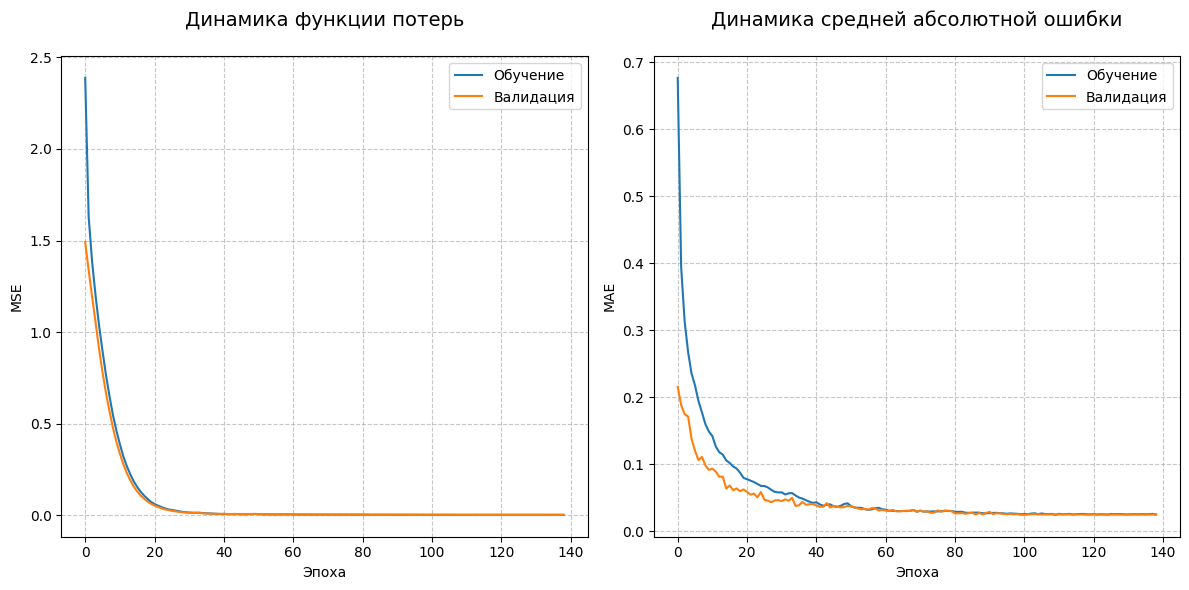

In [8]:
# Визуализация процесса обучения
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучение')
plt.plot(history.history['val_loss'], label='Валидация')
plt.title('Динамика функции потерь\n', fontsize=14)
plt.ylabel('MSE')
plt.xlabel('Эпоха')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Обучение')
plt.plot(history.history['val_mae'], label='Валидация')
plt.title('Динамика средней абсолютной ошибки\n', fontsize=14)
plt.ylabel('MAE')
plt.xlabel('Эпоха')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [9]:
# Оценка модели
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nЛучшая модель остановлена на эпохе: {early_stop.stopped_epoch}")
print(f"Тестовая MAE: {test_mae*100:.2f}%")
print(f"Тестовая MSE: {test_loss:.4f}")


Лучшая модель остановлена на эпохе: 138
Тестовая MAE: 2.53%
Тестовая MSE: 0.0029


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


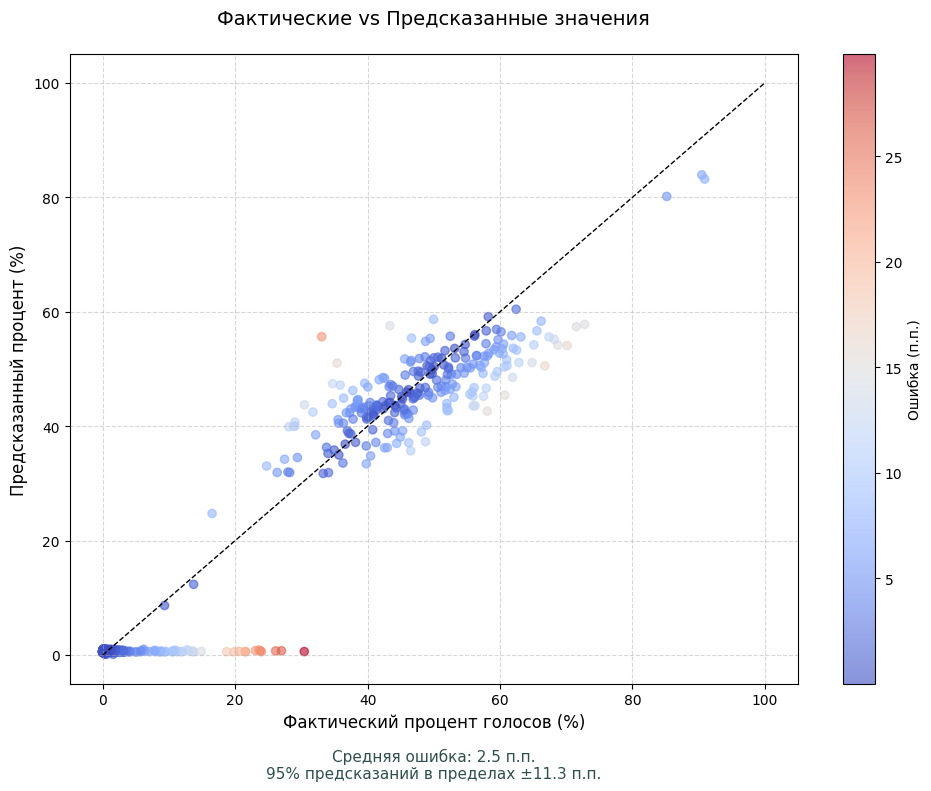

In [10]:
# Визуализация предсказаний
predictions = model.predict(X_test).flatten()

plt.figure(figsize=(10, 8))
plt.scatter(y_test*100, predictions*100, alpha=0.6, 
           c=np.abs(y_test - predictions)*100, cmap='coolwarm')
plt.colorbar(label='Ошибка (п.п.)')
plt.plot([0, 100], [0, 100], 'k--', lw=1)
plt.title('Фактические vs Предсказанные значения\n', fontsize=14)
plt.xlabel('Фактический процент голосов (%)', fontsize=12)
plt.ylabel('Предсказанный процент (%)', fontsize=12)
plt.grid(linestyle='--', alpha=0.5)
plt.annotate(f'Средняя ошибка: {test_mae*100:.1f} п.п.\n'
            f'95% предсказаний в пределах ±{np.percentile(np.abs(y_test - predictions)*100, 95):.1f} п.п.', 
            xy=(0.5, -0.15), xycoords='axes fraction',
            ha='center', fontsize=11, color='#2F4F4F')
plt.tight_layout()
plt.show()

Модель демонстрирует хорошие результаты, но есть потенциал для улучшения за счет более глубокого анализа данных, оптимизации гиперпараметров и расширения функционала. Результаты (MAE ~2.5%) можно считать удовлетворительными для задачи прогнозирования доли голосов на выборах.